In [1]:
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
csv_file = 'loans_risk_binary.csv'
data = pd.read_csv(csv_file, index_col=False)
y = data['loan_risk']
X = data.drop(columns=['loan_risk'], axis=1)


# Data preprocessing


In [312]:
Xtrain, Xtest_val, y_train, y_test_val = train_test_split(X,y, test_size = 0.3)
Xtest, Xval, y_test, y_val = train_test_split(Xtest_val,y_test_val, test_size = 0.5)

ordinal_features = Xtrain.columns[Xtrain.dtypes!='object']
categorical_features = Xtrain.columns[Xtrain.dtypes=='object']
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), 
                                      ('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

column_transformer = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                                     ('cat', categorical_transformer, categorical_features)])
column_transformer.fit(Xtrain)
X_train = column_transformer.transform(Xtrain)
X_test = column_transformer.transform(Xtest)
X_val = column_transformer.transform(Xval)
y_train_en = (y_train=='Charged Off').astype(int)
y_test_en = (y_test=='Charged Off').astype(int)
y_val_en = (y_val=='Charged Off').astype(int)

# Model training

In [324]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def keras_build():
    keras_clf = Sequential()
    keras_clf.add(Dense(32, input_shape=[X_train.shape[1]], activation='relu'))
    keras_clf.add(Dense(16, activation='relu'))
    # keras_clf.add(Dense(8, activation='relu'))
    # keras_clf.add(Dense(4, activation='relu'))    
    keras_clf.add(Dense(2, activation='softmax'))

    keras_clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return keras_clf

keras_wrapped = KerasClassifier(build_fn=keras_build)
keras_wrapped.fit(X_train, y_train_en, epochs=50, batch_size=64)

test_predictions = keras_wrapped.predict_proba(X_test).argmax(axis=1)
print('Test set metrics:\n', metrics.classification_report(y_test_en.values, test_predictions))

Epoch 1/50
426/426 [==============================] - 0s 494us/step - loss: 0.4342 - accuracy: 0.8288
Epoch 2/50
426/426 [==============================] - 0s 513us/step - loss: 0.4045 - accuracy: 0.8414
Epoch 3/50
426/426 [==============================] - 0s 511us/step - loss: 0.3988 - accuracy: 0.8447
Epoch 4/50
426/426 [==============================] - 0s 513us/step - loss: 0.3956 - accuracy: 0.8464
Epoch 5/50
426/426 [==============================] - 0s 504us/step - loss: 0.3932 - accuracy: 0.8478
Epoch 6/50
426/426 [==============================] - 0s 505us/step - loss: 0.3910 - accuracy: 0.8488
Epoch 7/50
426/426 [==============================] - 0s 504us/step - loss: 0.3890 - accuracy: 0.8485
Epoch 8/50
426/426 [==============================] - 0s 508us/step - loss: 0.3874 - accuracy: 0.8500
Epoch 9/50
426/426 [==============================] - 0s 507us/step - loss: 0.3859 - accuracy: 0.8508
Epoch 10/50
426/426 [==============================] - 0s 508us/step - loss: 0.384

# Plotting the calibration curve

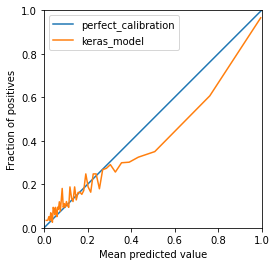

In [351]:
from sklearn.calibration import calibration_curve
prob_pos = keras_wrapped.predict_proba(X_test)[:,1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test_en, prob_pos, n_bins=50, strategy='quantile')
plt.plot(np.arange(0,1.1,.10),np.arange(0,1.1,.10),label='perfect_calibration')
plt.plot(mean_predicted_value, fraction_of_positives,label='keras_model')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.savefig('not_calibrated.png',dpi=600)

In [348]:
mean_predicted_value

array([0.00990917, 0.01718493, 0.0220817 , 0.02662825, 0.03076352,
       0.03449502, 0.03832061, 0.04194414, 0.04557834, 0.04882894,
       0.05217514, 0.05539844, 0.05879493, 0.0624401 , 0.06628353,
       0.07021565, 0.07478488, 0.07912592, 0.08334618, 0.08826507,
       0.09311898, 0.09761612, 0.10285138, 0.10768484, 0.11338844,
       0.11897116, 0.12630272, 0.13312584, 0.14053926, 0.14792948,
       0.15629304, 0.16512727, 0.17355238, 0.18231301, 0.19189929,
       0.2025944 , 0.21451382, 0.22602684, 0.23948636, 0.25448395,
       0.26944531, 0.28662059, 0.30478145, 0.32784619, 0.35631848,
       0.39137376, 0.43340692, 0.50910509, 0.76210043, 0.99628937])

(array([2558., 1565.,  806.,  408.,  209.,   68.,   39.,   26.,   17.,
         144.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f445d5e1210>])

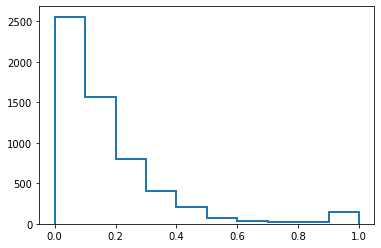

In [349]:
plt.hist(prob_pos, range=(0, 1), bins=10,histtype="step", lw=2)

# Fitting a calibrated classifier

In [357]:
from sklearn.calibration import CalibratedClassifierCV


calibrated_clf = CalibratedClassifierCV(keras_wrapped, cv='prefit',method='isotonic')
calibrated_clf.fit(X_val, y_val_en)

CalibratedClassifierCV(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f445ef0c350>,
                       cv='prefit', method='isotonic')

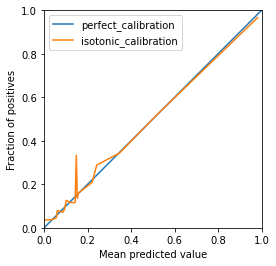

In [358]:
prob_pos = calibrated_clf.predict_proba(X_test)[:,1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test_en, prob_pos, n_bins=50, strategy='quantile')
plt.plot(np.arange(0,1.1,.10),np.arange(0,1.1,.10),label='perfect_calibration')
plt.plot(mean_predicted_value, fraction_of_positives,label='isotonic_calibration')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.savefig('calibrated.png',dpi=600)

(array([1.825e+03, 2.040e+03, 1.584e+03, 1.970e+02, 1.000e+00, 0.000e+00,
        4.900e+01, 0.000e+00, 2.400e+01, 1.200e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [<matplotlib.patches.Polygon at 0x7f445da044d0>])

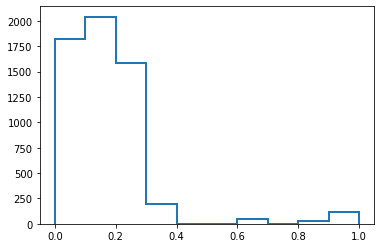

In [331]:
plt.hist(prob_pos, range=(0, 1), bins=10,histtype="step", lw=2)

In [287]:
test_predictions = calibrated_clf.predict_proba(X_test).argmax(axis=1)
print('Test set metrics:\n', metrics.classification_report(y_test_en.values, test_predictions))

Test set metrics:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      3217
           1       0.83      0.24      0.37       677

    accuracy                           0.86      3894
   macro avg       0.85      0.61      0.65      3894
weighted avg       0.86      0.86      0.82      3894



In [354]:
X_test.shape

(5840, 38)